<!-- ![alt text](image.png) -->
<!-- ![alt text](image-2.png) -->

[DHG](https://deephypergraph.readthedocs.io/en/latest/index.html)（DeepHypergraph）是一个基于PyTorch的深度学习库，用于图神经网络和超图神经网络的学习。
[GitHub](https://github.com/iMoonLab/DeepHypergraph/tree/main)

目前库版本的情况如下

python>=3.8
torch==1.13.1
numpy==1.24.1
安装cpu版pytorch的话，代码为
conda install pytorch==1.13.1 cpuonly -c pytorch

之后再安装dhg就可以了
`pip install dhg`

![alt text](image-1.png)
![alt text](image-2.png)

## 图上数据的信息聚合
首先我们构建一个图：

[0, 1, 2, 3, 4]
([(0, 1), (0, 2), (1, 3), (3, 4), (0, 4), (2, 4), (1, 4)], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
tensor([[0., 1., 1., 0., 1.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 0., 1.],
        [0., 1., 0., 0., 1.],
        [1., 1., 1., 1., 0.]])


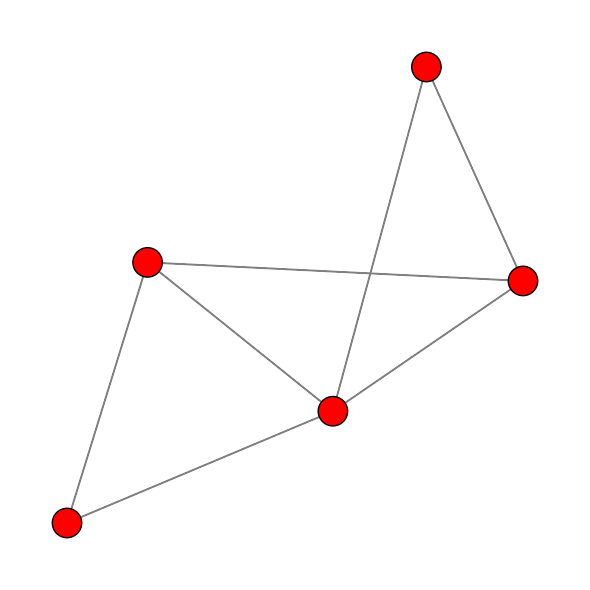

In [1]:
# %load ./test_graph.py
import torch
import dhg
import matplotlib.pyplot as plt
# 构建图
g = dhg.Graph(5, [(0, 1), (0, 2), (1, 3), (3, 4), (0, 4), (2, 4), (1, 4)], merge_op="mean")
print(g.v)
print(g.e)
print(g.A.to_dense())

# 也可以从邻接表构建图
# g = dhg.Graph.from_adj_list(5, [[0, 1, 2], [1, 3], [4, 3, 0, 2, 1]])
# 也可以用随机方法构建图
# g = dhg.random.graph_Gnm(5, 8)
# 随机初始化一个特征矩阵
# # Generate a vertex feature matrix with size 5x2
X = torch.rand(5, 2)

# 图的可视化
g.draw()
plt.show()


接下来对特征进行谱方法的信息聚合
$D_v^{-1/2}\hat{A} D_v^{-1/2}X$  ，其中$\hat{A} = A+I$


（GCN流程为$X' = \sigma\left(D_v^{-1/2}\hat{A} D_v^{-1/2}X\Theta\right)$，相当于对信息聚合之后进行了线性与非线性变换）

In [2]:
X_ = g.smoothing_with_GCN(X)
print(X_)
# # Print the inside Laplacian Matrix by GCN on the graph structure
# g.L_GCN.to_dense()
# # tensor([[0.2000, 0.2582, 0.2236, 0.2000, 0.2236],
# #         [0.2582, 0.3333, 0.0000, 0.2582, 0.0000],
# #         [0.2236, 0.0000, 0.2500, 0.2236, 0.2500],
# #         [0.2000, 0.2582, 0.2236, 0.2000, 0.2236],
# #         [0.2236, 0.0000, 0.2500, 0.2236, 0.2500]])
# # Print the vertex features after GCN-based smoothing
# X_
# # tensor([[0.5434, 0.6609],
# #         [0.5600, 0.5668],
# #         [0.3885, 0.6289],
# #         [0.5434, 0.6609],
# #         [0.3885, 0.6289]])


tensor([[0.6417, 0.6457],
        [0.5446, 0.6341],
        [0.4993, 0.7136],
        [0.4394, 0.5295],
        [0.6027, 0.8027]])


空域聚合，流程写作矩阵形式为$D_v^{-1} A X$

其中D_v：点度矩阵

In [3]:
# graphsage 空域聚合

X = torch.rand(5, 2)
# D_v diagnal matrix of vertex degree 
# D_v^{-1}*A*X
X_ = g.v2v(X, aggr="mean")
print(X_)


tensor([[0.2214, 0.5098],
        [0.5987, 0.4187],
        [0.6447, 0.3750],
        [0.3031, 0.5824],
        [0.3784, 0.5216]])


也可以将谱域与空域聚合的信息加和

In [4]:
# 谱域与空域聚合的信息加和
X_ = (g.smoothing_with_GCN(X) + g.v2v(X, aggr="mean"))/2
print(X_)

tensor([[0.2906, 0.4986],
        [0.5440, 0.4734],
        [0.5109, 0.3512],
        [0.3163, 0.5384],
        [0.4156, 0.5441]])


有向图的信息传递，目前模块只提供了空域上的信息聚合，比如source to target上的信息聚合为$D_v^{-1}A^{\top}X$

In [5]:
g = dhg.DiGraph(5, [(0, 3), (2, 4), (4, 2), (3, 1)])
X = torch.rand(5, 2)
X_src2dst = g.v2v(X, aggr="mean", direction="src2dst")
print(X_src2dst)

tensor([[0.0000, 0.0000],
        [0.7418, 0.1746],
        [0.4465, 0.7063],
        [0.8576, 0.3098],
        [0.8349, 0.0401]])


二分图（bigraph）的信息聚合

tensor([[1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [0., 0., 0., 1., 0.]])


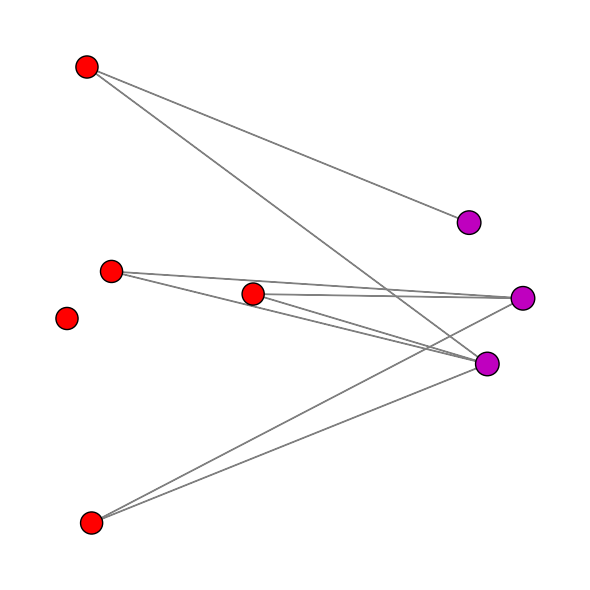

In [6]:
#随机初始化一个二部图，分两部U,V，节点数分别为3，5，随机生成8条边
g = dhg.random.bigraph_Gnm(3, 5, 8)


# B(3,5),B^T,稀疏U,V关联矩阵
print(g.B.to_dense())
# Generate feature matrix for vertices in set U and set V, respectively.
X_u, X_v = torch.rand(3, 2), torch.rand(5, 2)


g.draw()
plt.show()


B为U,V的bipartite adjacency matrix(3×5)，相当于超图的关联矩阵

特征聚合方式为$X_u = D_u^{-1} B X_v$，$X_v =  D_v^{-1} {B}^{\top} X_u$

In [7]:
# Propagate messages from vertices in set V to vertices in set U with mean aggregation
X_u_ = g.v2u(X_v, aggr="mean")
# Propagate messages from vertices in set U to vertices in set V with mean aggregation
# D_v^{-1} B^T X_u
X_v_ = g.u2v(X_u, aggr="mean")

## 超图的信息聚合

In [8]:
import torch
import dhg

hg = dhg.Hypergraph(5, [(0, 1, 2), (1, 3, 2), (1, 2), (0, 3, 4)])
print(hg.e)
print(hg.H.to_dense())

# 也可以构建随机超图，初始设定5点4边
# hg = dhg.random.hypergraph_Gnm(5, 4)
# print(hg.e)
# 随机初始化每个节点的两维特征
X = torch.rand(5, 2)


([(0, 1, 2), (1, 2, 3), (1, 2), (0, 3, 4)], [1.0, 1.0, 1.0, 1.0])
tensor([[1., 0., 0., 1.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [0., 1., 0., 1.],
        [0., 0., 0., 1.]])


特别地，此模块对于由超图构建普通图，除却star与clique的方法之外，还提供了一种由超图生成图的办法，来自 [HyperGCN](https://arxiv.org/pdf/1809.02589)

$(i_e,j_e) := \argmax_{i,j\in e}|S_i - S_j|$ 
![alt text](image-3.png)

In [9]:
# 特别地，可以由hypergraph构建g
g = dhg.Graph.from_hypergraph_hypergcn(hg, X)

超图上的信息聚合也分两种，谱域上的与空域上的。
首先来看谱域上的超图图卷积流程：
$$\mathcal{L}_{HGNN} = \sigma\left(\mathbf{D}_v^{-\frac{1}{2}} \mathbf{H} \mathbf{W}_e \mathbf{D}_e^{-1} \mathbf{H}^\top \mathbf{D}_v^{-\frac{1}{2}}\mathbf{X}\Theta\right)$$

其中的信息聚合
$D_v^{-1/2} H W_e D_e^{-1}H^T D_v^{-1/2}X$

In [10]:
# Message propagation from hyperedge to vertex
X_ = hg.smoothing_with_HGNN(X)

空域上的信息聚合,H: $n×m$

$X_e = D_e^{-1} H^T X_v$

$X_v = D_v^{-1} H X_e$

或者也可以在超边信息聚合到节点上时加上超边权重:
$X_v = D_v^{-1}  H W_e X_e$


In [11]:

# X_e = D_e^{-1}H^T X_v
# 点到超边
Y_ = hg.v2e(X, aggr="mean")
# 超边到点
X_ = hg.e2v(Y_,aggr="mean")

# X_v = D_v^{-1}  H W_e X_e
# 或者也可以加上超边权重
e2v_weight = torch.rand(len(hg.e2v_weight))
X_ = hg.e2v(Y_,e2v_weight=e2v_weight,aggr="mean")
 
# Or, you can pass messages from vertex set to vertex set with mean aggregation by:
# 也可以直接将这个v2e,e2v两步走写成以下v2v形式
X_ = hg.v2v(X, aggr="mean")

## 图卷积与超图卷积实现

模块提供了基本图卷积层与超图卷积层的代码可供调用，具体实现就是采用模块中上述所提到的信息聚合函数，再依需要进行特征变换。

下面是一个简单的GCN卷积层的代码:

In [12]:
import dhg
import torch
import torch.nn as nn

class GCNConv(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        bias: bool = True,
        drop_rate: float = 0.5,
    ):
        super().__init__()
        self.act = nn.ReLU(inplace=True)
        self.drop = nn.Dropout(drop_rate)
        self.theta = nn.Linear(in_channels, out_channels, bias=bias)

    def forward(self, X: torch.Tensor, g: dhg.Graph) -> torch.Tensor:
        X = self.theta(X)
        X_ = g.smoothing_with_GCN(X)
        X_ = self.drop(self.act(X_))
        return X_
    
g = dhg.Graph(5, [(0, 1), (0, 2), (1, 3), (3, 4), (0, 4), (2, 4), (1, 4)])
X = torch.rand(5,2)
gcn = GCNConv(2,1)
X_ = gcn(X,g)
# print(X_)

下面是一个超图节点分类的示例代码，借助了模块自带的Cooking200数据集，模型为由两个超图卷积层HGNNConv封装好的节点分类模型HGNN，损失为交叉熵损失。
模型训练与评估大同小异，我们来看其中比较核心的几句代码：
```python
G = Hypergraph(data["num_vertices"], data["edge_list"])
net = HGNN(X.shape[1], 32, data["num_classes"], use_bn=True)
outs = net(X, G)
```
也就是说，我们需要输入的是超图G与初始特征矩阵X，
G的确定需要节点数与超边列表（形如[(0, 1, 2), (1, 2)]），模型初始化时需要输入层的特征维数、隐藏层维数、输出层（分类层）维数，调用时输入特征矩阵X和超图G。




In [13]:
import time
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn.functional as F

from dhg import Hypergraph
from dhg.data import Cooking200
from dhg.models import HGNN
from dhg.random import set_seed
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator
def train(net, X, A, lbls, train_idx, optimizer, epoch):
    net.train()

    st = time.time()
    optimizer.zero_grad()
    outs = net(X, A)
    outs, lbls = outs[train_idx], lbls[train_idx]
    loss = F.cross_entropy(outs, lbls)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Time: {time.time()-st:.5f}s, Loss: {loss.item():.5f}")
    return loss.item()


@torch.no_grad()
def infer(net, X, A, lbls, idx, test=False):
    net.eval()
    outs = net(X, A)
    outs, lbls = outs[idx], lbls[idx]
    if not test:
        res = evaluator.validate(lbls, outs)
    else:
        res = evaluator.test(lbls, outs)
    return res

if __name__ == "__main__":
    set_seed(2021)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])
    data = Cooking200()

    X, lbl = torch.eye(data["num_vertices"]), data["labels"]
    G = Hypergraph(data["num_vertices"], data["edge_list"])
    train_mask = data["train_mask"]
    val_mask = data["val_mask"]
    test_mask = data["test_mask"]

    net = HGNN(X.shape[1], 32, data["num_classes"], use_bn=True)
    optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=5e-4)

    X, lbl = X.to(device), lbl.to(device)
    G = G.to(device)
    net = net.to(device)

    best_state = None
    best_epoch, best_val = 0, 0
    for epoch in range(200):
        # train
        train(net, X, G, lbl, train_mask, optimizer, epoch)
        # validation
        if epoch % 1 == 0:
            with torch.no_grad():
                val_res = infer(net, X, G, lbl, val_mask)
            if val_res > best_val:
                print(f"update best: {val_res:.5f}")
                best_epoch = epoch
                best_val = val_res
                best_state = deepcopy(net.state_dict())
    print("\ntrain finished!")
    print(f"best val: {best_val:.5f}")
    # test
    print("test...")
    net.load_state_dict(best_state)
    res = infer(net, X, G, lbl, test_mask, test=True)
    print(f"final result: epoch: {best_epoch}")
    print(res)

Epoch: 0, Time: 0.57075s, Loss: 2.99680
update best: 0.05000
Epoch: 1, Time: 0.44458s, Loss: 2.71560
Epoch: 2, Time: 0.34824s, Loss: 2.34183
Epoch: 3, Time: 0.33715s, Loss: 2.17803
Epoch: 4, Time: 0.35491s, Loss: 2.04616
Epoch: 5, Time: 0.35887s, Loss: 1.90518
Epoch: 6, Time: 0.32666s, Loss: 1.78512
Epoch: 7, Time: 0.33858s, Loss: 1.66366
Epoch: 8, Time: 0.31702s, Loss: 1.53951
Epoch: 9, Time: 0.32943s, Loss: 1.43321
Epoch: 10, Time: 0.33378s, Loss: 1.34211
Epoch: 11, Time: 0.30918s, Loss: 1.22630
Epoch: 12, Time: 0.30787s, Loss: 1.11867
Epoch: 13, Time: 0.34970s, Loss: 1.01440
Epoch: 14, Time: 0.33104s, Loss: 0.93420
Epoch: 15, Time: 0.30302s, Loss: 0.83996
Epoch: 16, Time: 0.30275s, Loss: 0.76163
Epoch: 17, Time: 0.30708s, Loss: 0.68340
update best: 0.05500
Epoch: 18, Time: 0.33452s, Loss: 0.61747
update best: 0.07000
Epoch: 19, Time: 0.31939s, Loss: 0.56980
update best: 0.08500
Epoch: 20, Time: 0.30552s, Loss: 0.50861
update best: 0.09500
Epoch: 21, Time: 0.35976s, Loss: 0.44348
upd

本模块提供了一种自动超参选择的方法，借助optuna模块进行实现
<!-- 
TPE算法通过构建一个树形结构的概率模型来估计参数空间中的目标函数的概率分布。
然后，TPE算法根据这个概率模型，通过优化期望改进来选择下一个要尝试的参数值，以便在下一次迭代中获得更好的结果。
TPE算法同时维护两个概率模型，一个用于表示目标函数的条件概率分布l(x)，另一个用于表示条件概率分布的先验概率分布g(x), l(x)/g(x)最大化时对应的超参作为下一组搜索值。 -->

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

from dhg import Hypergraph
from dhg.data import Cooking200
from dhg.models import HGNNP
from dhg.random import set_seed
from dhg.experiments import HypergraphVertexClassificationTask as Task
from dhg.metrics import HypergraphVertexClassificationEvaluator as Evaluator
# TPE（Tree-structured Parzen Estimator）
def structure_builder(trial):
    global hg_base, g
    cur_hg: Hypergraph = hg_base.clone()
    return cur_hg


def model_builder(trial):
    return HGNNP(dim_features, trial.suggest_int("hidden_dim", 10, 20), num_classes, use_bn=True)


def train_builder(trial, model):
    optimizer = optim.Adam(
        model.parameters(),
        lr=trial.suggest_loguniform("lr", 1e-4, 1e-2),
        weight_decay=trial.suggest_loguniform("weight_decay", 1e-4, 1e-2),
    )
    criterion = nn.CrossEntropyLoss()
    return {
        "optimizer": optimizer,
        "criterion": criterion,
    }


if __name__ == "__main__":
    work_root = "./temp"
    set_seed(2022)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    data = Cooking200()
    dim_features = data["num_vertices"]
    num_classes = data["num_classes"]
    hg_base = Hypergraph(data["num_vertices"], data["edge_list"])
    input_data = {
        "features": torch.eye(data["num_vertices"]),
        "labels": data["labels"],
        "train_mask": data["train_mask"],
        "val_mask": data["val_mask"],
        "test_mask": data["test_mask"],
    }
    evaluator = Evaluator(["accuracy", "f1_score", {"f1_score": {"average": "micro"}}])
    task = Task(
        work_root, input_data, model_builder, train_builder, evaluator, device, structure_builder=structure_builder,
    )
    task.run(200, 50, "maximize")

[I 2024-07-27 15:29:40,998] Logs will be saved to /home/yunping/DeepHypergraph/temp/2024-07-27--15-29-40/log.txt
[I 2024-07-27 15:29:40,999] Files in training will be saved in /home/yunping/DeepHypergraph/temp/2024-07-27--15-29-40
[I 2024-07-27 15:29:41,000] Random seed is 2022
[I 2024-07-27 15:29:41,002] A new study created in memory with name: no-name-4af9ff71-16f7-4141-ae0f-82d435f8d0b1
/tmp/ipykernel_135227/1073263904.py:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr=trial.suggest_loguniform("lr", 1e-4, 1e-2),
/tmp/ipykernel_135227/1073263904.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay=trial.suggest_loguniform("weight_decay", 1e-4, 1e-2),

[I 2024-07-27 15:30:39,578] Trial 4 finished with value: 0.44999998807907104 and parameters: {'hidden_dim': 19, 'lr': 0.008205190552892963, 'weight_decay': 0.0005446140912512398}. Best is trial 2 with value: 0.5199999809265137.
[I 2024-07-27 15:30:40,730] Trial 5 pruned. 
[I 2024-07-27 15:30:42,082] Trial 6 pruned. 
[I 2024-07-27 15:30:43,178] Trial 7 pruned. 
[I 2024-07-27 15:30:44,296] Trial 8 pruned. 
[I 2024-07-27 15:30:45,526] Trial 9 pruned. 
[I 2024-07-27 15:30:46,888] Trial 10 pruned. 
[I 2024-07-27 15:30:48,063] Trial 11 pruned. 
[I 2024-07-27 15:30:51,016] Trial 12 pruned. 
[I 2024-07-27 15:30:52,224] Trial 13 pruned. 
[I 2024-07-27 15:30:55,971] Trial 14 pruned. 
[I 2024-07-27 15:31:00,178] Trial 15 pruned. 
[I 2024-07-27 15:31:12,478] Trial 16 finished with value: 0.4950000047683716 and parameters: {'hidden_dim': 15, 'lr': 0.003984478131058521, 'weight_decay': 0.0015799420199334793}. Best is trial 2 with value: 0.5199999809265137.
[I 2024-07-27 15:31:13,878] Trial 17 pruned

## 其他
特征在欧式与双曲空间的可视化

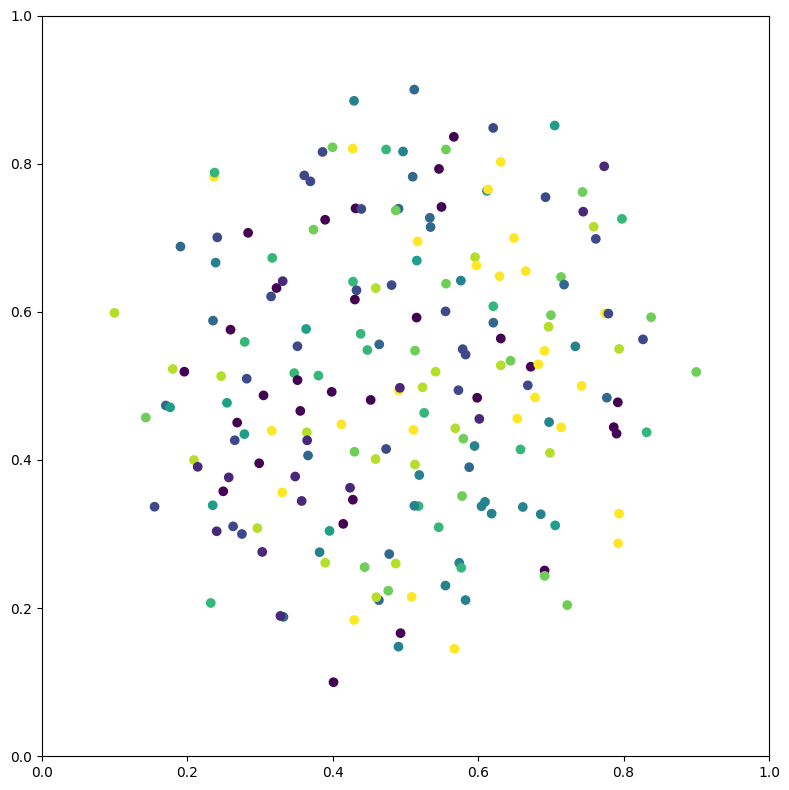

In [15]:
import dhg
import numpy as np
import matplotlib.pyplot as plt
import dhg.visualization as vis
lbl = (np.random.rand(200)*10).astype(int)
ft = dhg.random.normal_features(lbl)
vis.draw_in_euclidean_space(ft, lbl)
# lbl = (np.random.rand(200)*10).astype(int)
# ft = dhg.random.normal_features(lbl)
plt.show()



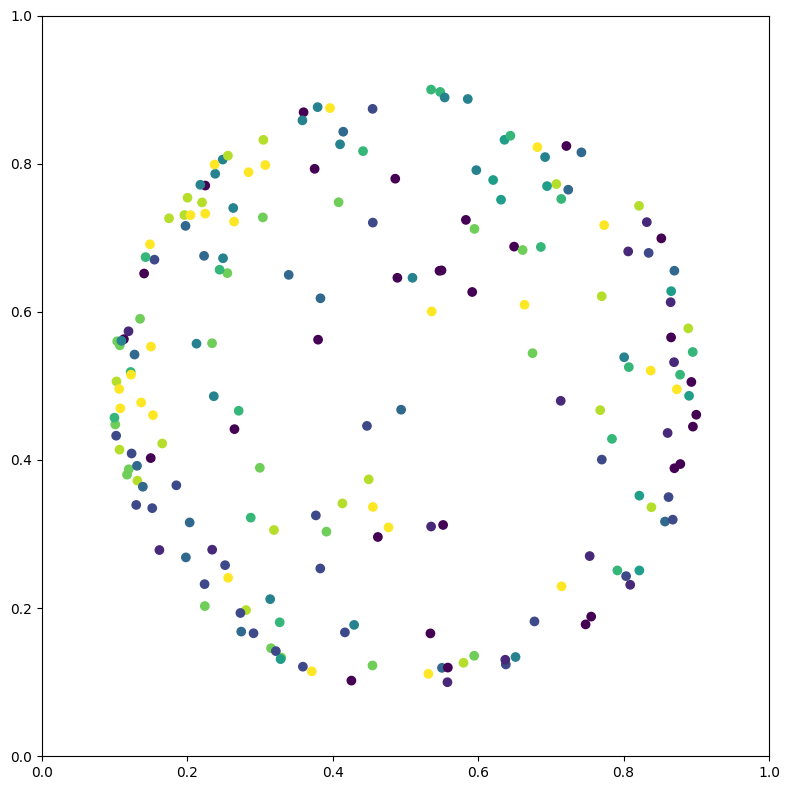

In [16]:
vis.draw_in_poincare_ball(ft, lbl)
plt.show()